In [1]:
import argparse
import functools
import os
import pathlib
import sys

os.environ["MUJOCO_GL"] = "osmesa"

import numpy as np
import ruamel.yaml as yaml

import exploration as expl
import models
import tools
import envs.wrappers as wrappers
from parallel import Parallel, Damy

import torch
from torch import nn
from torch import distributions as torchd

import matplotlib.pyplot as plt

from dreamer import Dreamer
import pickle
import envs.lander2


In [2]:
with open('configs.pkl', 'rb') as f:
    config = pickle.load(f)

config.logdir = 'logs/testing/20250529_161542'
logdir = pathlib.Path(config.logdir).expanduser()
config.traindir = logdir / "train_eps"
config.evaldir = logdir / "eval_eps"
config.parallel = False

with open('configs.pkl', 'wb') as f:
    pickle.dump(config, f)

In [3]:
with open('configs.pkl', 'rb') as f:
    config = pickle.load(f)

def count_steps(folder):
    return sum(int(str(n).split("-")[-1][:-4]) - 1 for n in folder.glob("*.npz"))

def make_dataset(episodes, config):
    generator = tools.sample_episodes(episodes, config.batch_length)
    dataset = tools.from_generator(generator, config.batch_size)
    return dataset

def make_dataset(episodes, config):
    generator = tools.sample_episodes(episodes, config.batch_length)
    dataset = tools.from_generator(generator, config.batch_size)
    return dataset


def make_env(config):
    suite, task = config.task.split("_", 1)
    import envs.lander2 as lander

    env = lander.LanderEnv(task)
    env = wrappers.NormalizeActions(env)
    env = wrappers.TimeLimit(env, config.time_limit)
    env = wrappers.SelectAction(env, key="action")
    env = wrappers.UUID(env)

    return env


logdir = pathlib.Path(config.logdir).expanduser()

step = count_steps(config.traindir)
logger = tools.Logger(logdir, config.action_repeat * step)

test_env = make_env(config)
test_env = Damy(test_env)
if config.offline_traindir:
    directory = config.offline_traindir.format(**vars(config))
else:
    directory = config.traindir
train_eps = tools.load_episodes(directory, limit=config.dataset_size)
train_dataset = make_dataset(train_eps, config)

acts = test_env.action_space
config.num_actions = acts.n if hasattr(acts, "n") else acts.shape[0]

agent = Dreamer(
        test_env.observation_space,
        test_env.action_space,
        config,
        logger,
        train_dataset,
    ).to(config.device)
agent.requires_grad_(requires_grad=False)

if (logdir / "latest.pt").exists():
    checkpoint = torch.load(logdir / "latest.pt", weights_only=True)
    agent.load_state_dict(checkpoint["agent_state_dict"])
    tools.recursively_load_optim_state_dict(agent, checkpoint["optims_state_dict"])
    agent._should_pretrain._once = False

Encoder CNN shapes: {}
Encoder MLP shapes: {'state': (12,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'state': (12,)}
Optimizer model_opt has 16444172 variables.
Optimizer actor_opt has 1054728 variables.
Optimizer value_opt has 1181439 variables.


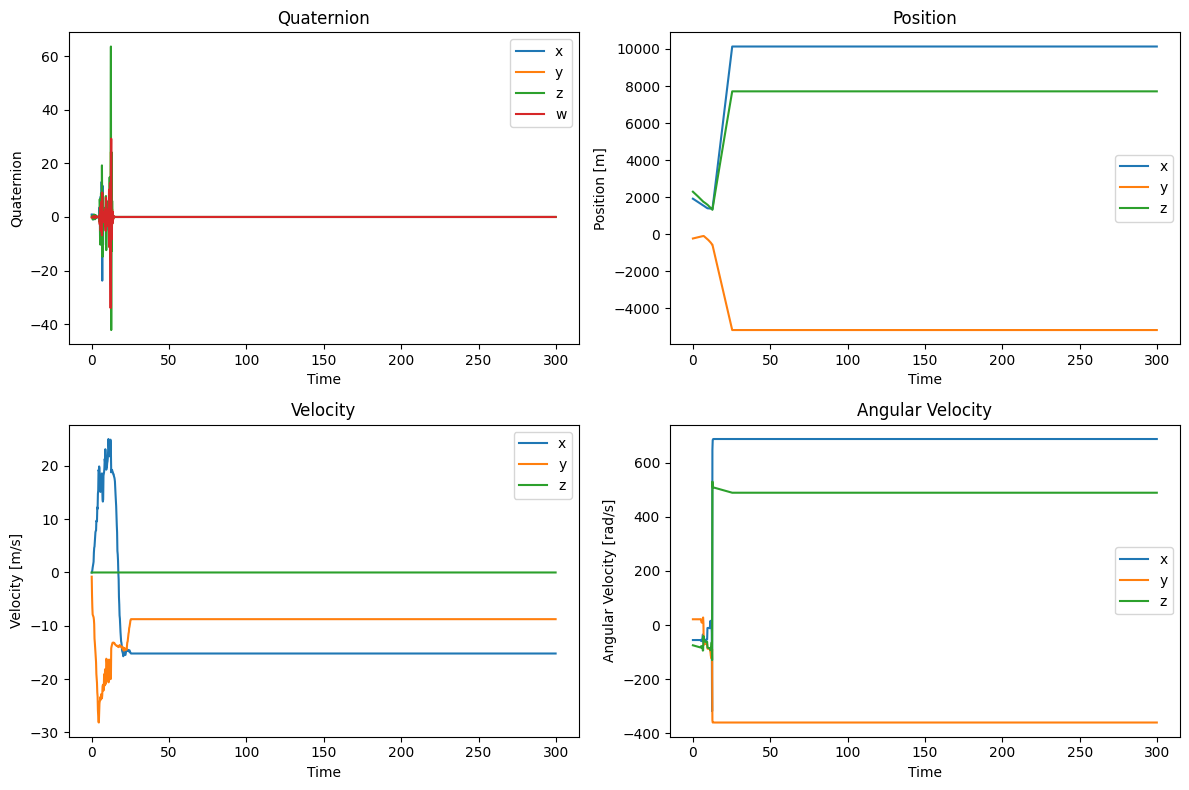

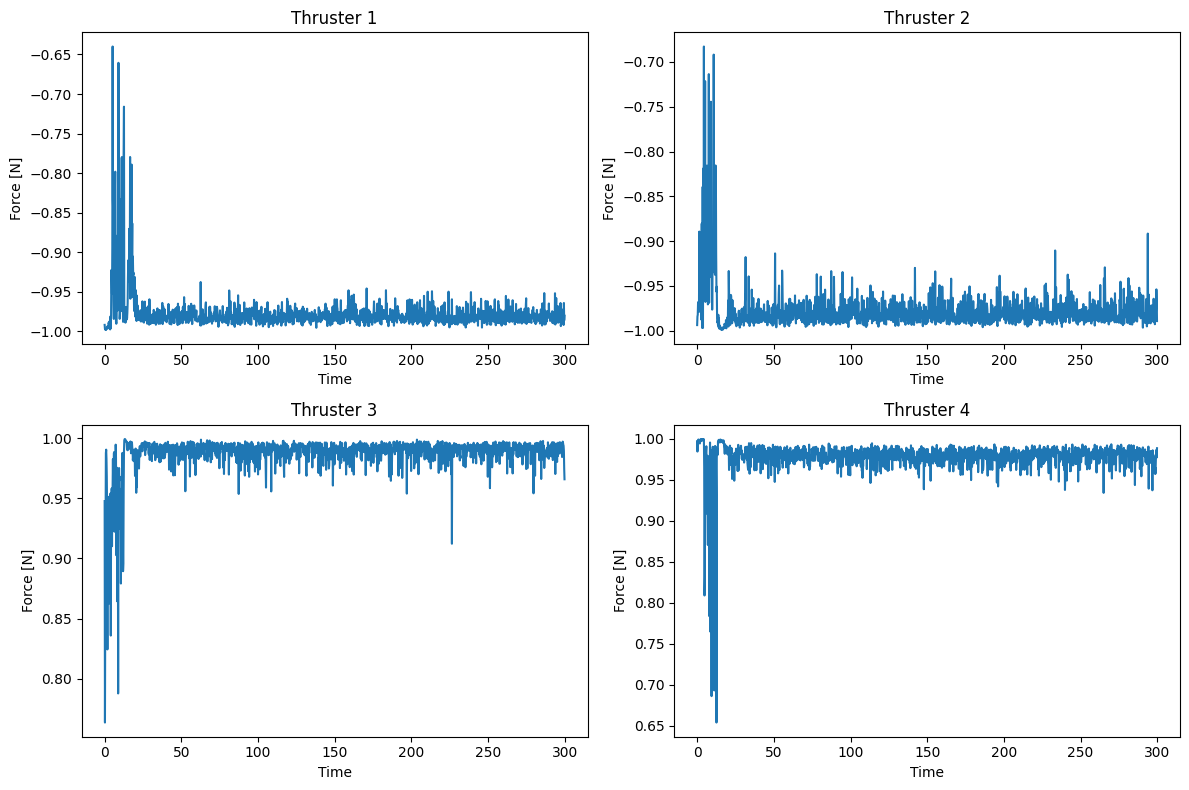

In [27]:
def convert(value, precision=32):
    value = np.array(value)
    if np.issubdtype(value.dtype, np.floating):
        dtype = {16: np.float16, 32: np.float32, 64: np.float64}[precision]
    elif np.issubdtype(value.dtype, np.signedinteger):
        dtype = {16: np.int16, 32: np.int32, 64: np.int64}[precision]
    elif np.issubdtype(value.dtype, np.uint8):
        dtype = np.uint8
    elif np.issubdtype(value.dtype, bool):
        dtype = bool
    else:
        raise NotImplementedError(value.dtype)
    return value.astype(dtype)

step, episode = 0, 0
done = np.ones(1, bool)
length = np.zeros(1, np.int32)
obs = [None]
indices = [index for index, d in enumerate(done) if d]      # find indices of done envs
results = [test_env.reset() for i in indices]                # reset done envs
results = [r() for r in results]                            # call the reset functions
for index, result in zip(indices, results): # replacing obs with reset results
    t = result.copy()
    t = {k: convert(v) for k, v in t.items()}
    # action will be added to transition in add_to_cache
    t["reward"] = 0.0
    t["discount"] = 1.0
    obs[index] = result
obs = {k: np.stack([o[k] for o in obs]) for k in obs[0] if "log_" not in k}
agent_state = None
reward = [0]

time = np.arange(0,300,0.2)
state = obs['log/dynstates']
state_hist = np.zeros((len(time), state.shape[1]))
control_hist = np.zeros((len(time), 4))
action, agent_state = agent(obs, done, agent_state, training=False)



# obs, reward, done = zip(*[p[:3] for p in results])
# print(obs)
# print(reward)
# print(done)


for i, t in enumerate(time):
    action, agent_state = agent(obs, done, agent_state, training=False)
    if isinstance(action, dict):
        action = [
            {k: np.array(action[k].detach().cpu()) for k in action}
        ]
    else:
        action = np.array(action)
    
    result = [e.step(a) for e, a in zip([test_env], action)] # step each env with the corresponding action
    result = [r() for r in result]
    obs, reward, done = zip(*[p[:3] for p in result])
    obs = {k: np.stack([o[k] for o in obs]) for k in obs[0] if "log_" not in k}
    # reward = list(reward)
    done = np.array(done)
    episode += 0
    length += 1
    step += 1
    length *= 1 - 0
    state_hist[i,:] = obs['log/dynstates']
    control_hist[i,:] = action[0]['action'][0,:4]

quat = state_hist[:, 0:4]
pos = state_hist[:, 4:7]
vel = state_hist[:, 7:10]
ang_vel = state_hist[:, 10:13]    
fig = plt.figure(1, figsize=(12, 8))
ax = fig.add_subplot(2, 2, 1)
ax.plot(time, quat)
ax.set_xlabel("Time")
ax.set_ylabel("Quaternion")
ax.set_title("Quaternion")
ax.legend(["x", "y", "z", "w"])
ax = fig.add_subplot(2, 2, 2)
ax.plot(time,pos)
ax.set_xlabel("Time")
ax.set_ylabel("Position [m]")
ax.set_title("Position")
ax.legend(["x", "y", "z"])
ax = fig.add_subplot(2, 2, 3)
ax.plot(time,vel)
ax.set_xlabel("Time")
ax.set_ylabel("Velocity [m/s]")
ax.set_title("Velocity")
ax.legend(["x", "y", "z"])
ax = fig.add_subplot(2, 2, 4)
ax.plot(time,ang_vel)
ax.set_xlabel("Time")
ax.set_ylabel("Angular Velocity [rad/s]")
ax.legend(["x", "y", "z"])
ax.set_title("Angular Velocity")
plt.tight_layout()
plt.show()

control = action[0]['action']
fig2 = plt.figure(2, figsize=(12, 8))
ax2 = fig2.add_subplot(2, 2, 1)
ax2.plot(time, control_hist[:,0])
ax2.set_xlabel("Time")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster 1")
ax2 = fig2.add_subplot(2, 2, 2)
ax2.plot(time,control_hist[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster 2")
ax2 = fig2.add_subplot(2, 2, 3)
ax2.plot(time,control_hist[:,2])
ax2.set_xlabel("Time")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster 3")
ax2 = fig2.add_subplot(2, 2, 4)
ax2.plot(time,control_hist[:,3])
ax2.set_xlabel("Time")
ax2.set_ylabel("Force [N]")
ax2.set_title("Thruster 4")
plt.tight_layout()
plt.show()